<a href="https://colab.research.google.com/github/Vardhanksai/DAUP_Projects/blob/main/DAUP_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1 - Train Acc: 0.1935, Val Acc: 0.2155
Epoch 2 - Train Acc: 0.3580, Val Acc: 0.5645
Epoch 3 - Train Acc: 0.6711, Val Acc: 0.7290
Epoch 4 - Train Acc: 0.7729, Val Acc: 0.7730
Epoch 5 - Train Acc: 0.8171, Val Acc: 0.7705


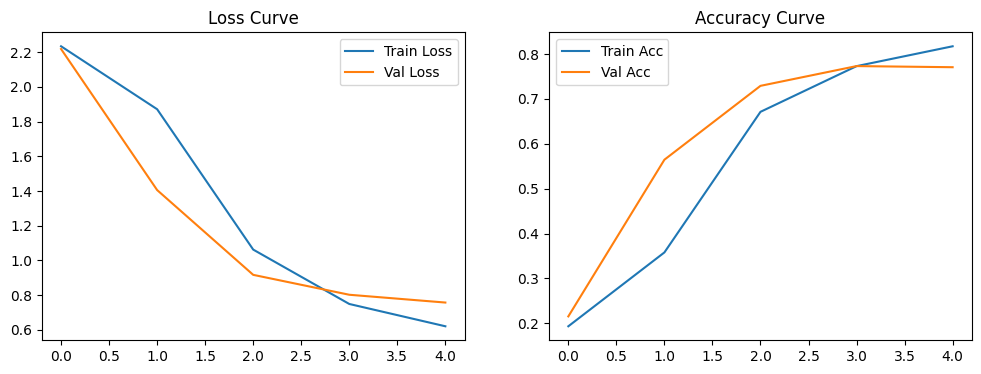


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      1744
           1       0.88      0.88      0.88      5099
           2       0.93      0.81      0.86      4149
           3       0.66      0.77      0.71      2882
           4       0.88      0.73      0.80      2523
           5       0.70      0.82      0.76      2384
           6       0.66      0.74      0.70      1977
           7       0.78      0.86      0.82      2019
           8       0.92      0.32      0.47      1660
           9       0.67      0.69      0.68      1595

    accuracy                           0.77     26032
   macro avg       0.77      0.75      0.74     26032
weighted avg       0.79      0.77      0.77     26032



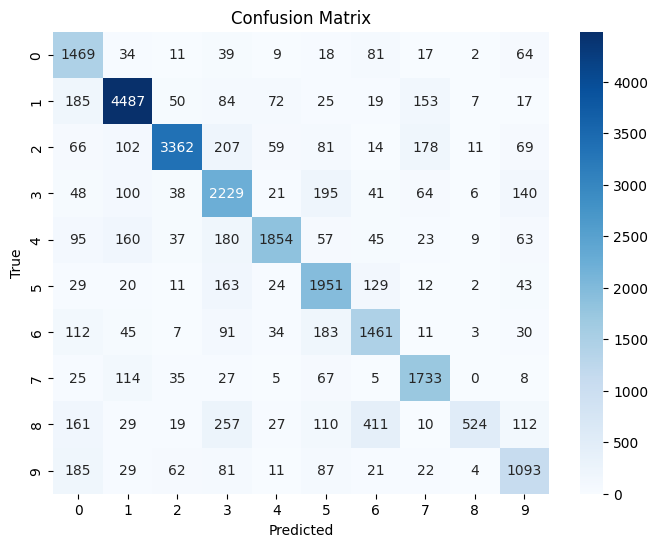

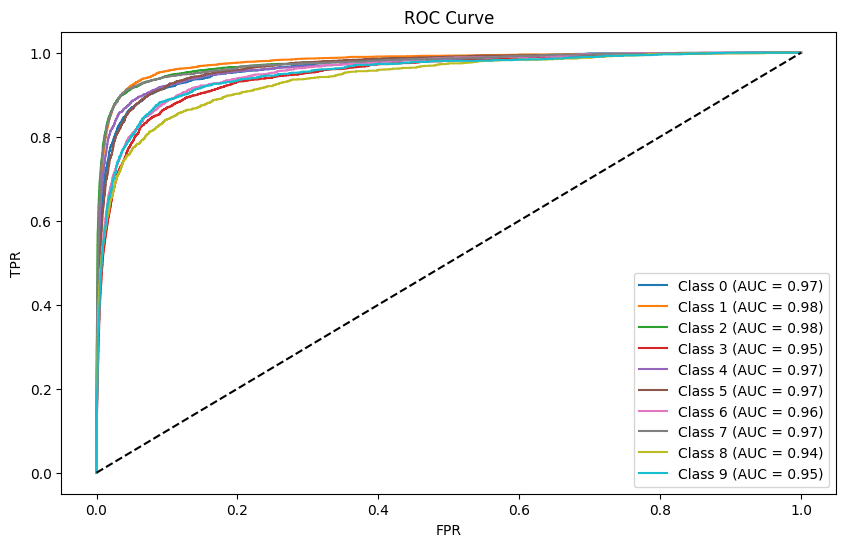


Z-test (Even vs Odd Acc): Z = -19.7987, p = 0.0000
T-test (Train vs Val Acc): t = -0.2967, p = 0.7743
Epoch 1 - Train Acc: 0.1933, Val Acc: 0.1935
Epoch 2 - Train Acc: 0.4404, Val Acc: 0.6415
Epoch 3 - Train Acc: 0.7312, Val Acc: 0.7500
Epoch 1 - Train Acc: 0.1924, Val Acc: 0.1915
Epoch 2 - Train Acc: 0.3738, Val Acc: 0.5815
Epoch 3 - Train Acc: 0.6994, Val Acc: 0.7445
Epoch 1 - Train Acc: 0.1862, Val Acc: 0.1915
Epoch 2 - Train Acc: 0.3315, Val Acc: 0.5185
Epoch 3 - Train Acc: 0.6670, Val Acc: 0.7270
ANOVA (3 runs accuracy): F = nan, p = nan


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:567: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
<ipython-input-2-4239fef1127b>:222: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_anova = f_oneway(*[[acc] for acc in accuracies])


In [ ]:
!pip install scipy scikit-learn matplotlib seaborn --quiet

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import ttest_ind, f_oneway, norm
from scipy.io import loadmat
import seaborn as sns
import os


def load_svhn(path):
    data = loadmat(path)
    images = np.transpose(data['X'], (3, 0, 1, 2)) / 255.0
    labels = data['y'].flatten()
    labels[labels == 10] = 0
    return images.astype(np.float32), labels.astype(np.int64)

!wget -q http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -q http://ufldl.stanford.edu/housenumbers/test_32x32.mat

x_train_full, y_train_full = load_svhn("train_32x32.mat")
x_test, y_test = load_svhn("test_32x32.mat")

# Use a subset for faster training
subset_size = 10000
x_train_full, y_train_full = x_train_full[:subset_size], y_train_full[:subset_size]


class SVHNDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

transform = transforms.Compose([transforms.ToTensor()])

full_dataset = SVHNDataset(x_train_full, y_train_full, transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_dataset = SVHNDataset(x_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=1000)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def train_model(model, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                val_loss += criterion(output, y).item()
                preds = output.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)
        print(f"Epoch {epoch+1} - Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")
    return model, train_accs, val_accs, train_losses, val_losses


model = CNN()
model, train_accs, val_accs, train_losses, val_losses = train_model(model)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()


torch.save(model.state_dict(), "cnn_svhn.pth")
model_loaded = CNN()
model_loaded.load_state_dict(torch.load("cnn_svhn.pth"))
model_loaded.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model_loaded(x)
        prob = torch.softmax(out, dim=1)
        preds = torch.argmax(prob, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(prob.cpu().numpy())
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC + AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve"); plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

# Statistical Tests
# Z-test
even_mask = np.isin(all_labels, [0,2,4,6,8])
odd_mask = np.isin(all_labels, [1,3,5,7,9])
even_acc = (all_preds[even_mask] == all_labels[even_mask]).astype(int)
odd_acc = (all_preds[odd_mask] == all_labels[odd_mask]).astype(int)
p1, p2 = even_acc.mean(), odd_acc.mean()
n1, n2 = len(even_acc), len(odd_acc)
pooled = (even_acc.sum() + odd_acc.sum()) / (n1 + n2)
z = (p1 - p2) / np.sqrt(pooled * (1 - pooled) * (1/n1 + 1/n2))
p_value_z = 2 * (1 - norm.cdf(abs(z)))
print(f"\nZ-test (Even vs Odd Acc): Z = {z:.4f}, p = {p_value_z:.4f}")

# T-test
t_stat, p_t = ttest_ind(train_accs, val_accs)
print(f"T-test (Train vs Val Acc): t = {t_stat:.4f}, p = {p_t:.4f}")

# ANOVA
accuracies = []
for i in range(3):
    m = CNN()
    _, train_accs_i, _, _, _ = train_model(m, epochs=3)
    accuracies.append(train_accs_i[-1])
f_stat, p_anova = f_oneway(*[[acc] for acc in accuracies])
print(f"ANOVA (3 runs accuracy): F = {f_stat:.4f}, p = {p_anova:.4f}")
